# 0. Introduction

In this entry we are going to consider the price of Bitcoin from August 2010 to November 2019. First we show that the log-returns are not normally distributed, and then we run a $K$-means clustering algorithm on the monthly volatilities to classify different volatility regimes and then find the probability of swtiching from one regime to another. Finally we speculate, using the Kolmogorov-Smirnov distance on samples, as to whether months within the same cluster come from the same distribution. The Jupyter notebook and .html file for this post can be found on Github: [https://github.com/dhughesln3/bitcoin_kmeans](https://github.com/dhughesln3/bitcoin_kmeans).

First, we need to get the necessary data, so we import some data analysis packages and use the json package to read the data from the coindesk.com api.

In [1]:
from pandas_datareader import data, wb
import pandas as pd
import requests
import json
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
%matplotlib inline

In [2]:
start='2010-08-01'
end='2019-11-06'
bitcoin_prices_dict=json.loads(requests.get('https://api.coindesk.com/v1/bpi/historical/close.json?start='+start+'&end='+end).text)['bpi']

Now that we have the Bitcoin price data, we convert it into a pandas dataframe and use the date to index it.

In [3]:
s=pd.Series(bitcoin_prices_dict, name='Bitcoin Price (USD)')
s.index.name='Date'
s.reset_index()
bitcoin_prices=pd.DataFrame(s)

# 1. Bitcoin Returns Are Not Log-Normal

Here we investigate whether the log-returns of Bitcoin prices were distributed log-normally. This is an assumption in certain pricing models, such as Black-Scholes for dervative pricing. However, it is not alwayd valid, and we will see that we can reject this assumption for Bitcoin prices.

First, let's check the head of the Bitcoin price dataframe:

In [4]:
bitcoin_prices.head()

,Bitcoin Price (USD)
Date,
2010-08-01,0.0611
2010-08-02,0.0600
2010-08-03,0.0600
2010-08-04,0.0570
2010-08-05,0.0610


Plotting this over time, we get seemingly exponential growth until a crash near the end of 2017 from which it still has not recovered.

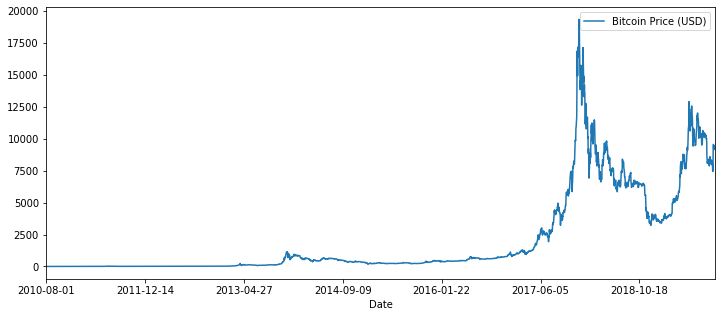

In [5]:
bitcoin_prices.plot(figsize=(12,5))

In [6]:
bitcoin_prices.describe()

,Bitcoin Price (USD)
count,3385.000000
mean,2083.394760
std,3405.060549
min,0.057000
25%,13.810000
50%,415.091000
75%,2712.157500
max,19343.040000


Now, let's add in the returns and the log-returns:

In [7]:
bitcoin_prices['returns']=bitcoin_prices/bitcoin_prices.shift(1)
bitcoin_prices['log_returns']=np.log(bitcoin_prices['returns'])

Looking at the return rate over time, we see some peroids of volatility and some of relative calm:

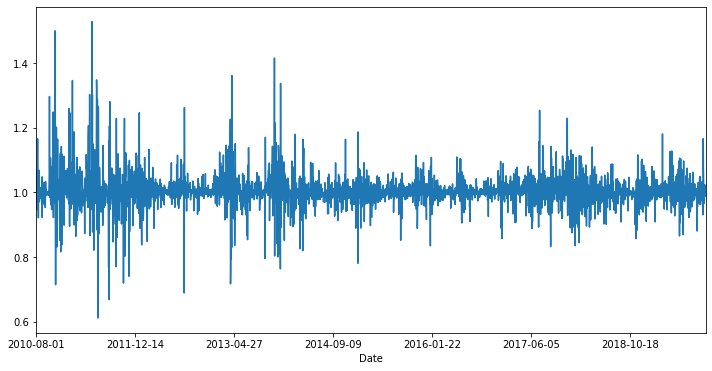

In [8]:
bitcoin_prices['returns'].plot(kind='line',figsize=(12,6))

In [9]:
m=loc=bitcoin_prices['log_returns'][1:].mean()
s=loc=bitcoin_prices['log_returns'][1:].std()

Running the the normality test from the scipy.stats package on the log-returns, we see that it fails it with a tiny $p$-value. So we can confidently reject the assumption that the returns are log-normally distributed based on this.

In [10]:
stats.normaltest(bitcoin_prices['log_returns'], nan_policy='omit')

NormaltestResult(statistic=675.3618000417742, pvalue=2.2235580747294985e-147)

This shows that the skew and kurtosis (specifically, the sum of their squares) of the logarithmic returns is very far from that of a normal distribution, about 675 standard deviations (!) away from what one would expect. So we can confidently reject the assumption of log-normal returns for Bitcoin over this time peroid. At first, the result of this test is surprising. However, the log-normal hypothesis is often false over the long term and more importantly it is not particularly useful for developing investment startegies, as such a model is bad at predicting tail events, precisely the kind of events strategies exist to deal with in the first place.

Let's explore this a bit further. We will compare the distribution to that of a normal distribution with the same number of samples and the same mean and standard deviation:

Text(0.5, 1.0, 'Log Returns of Bitcoin')

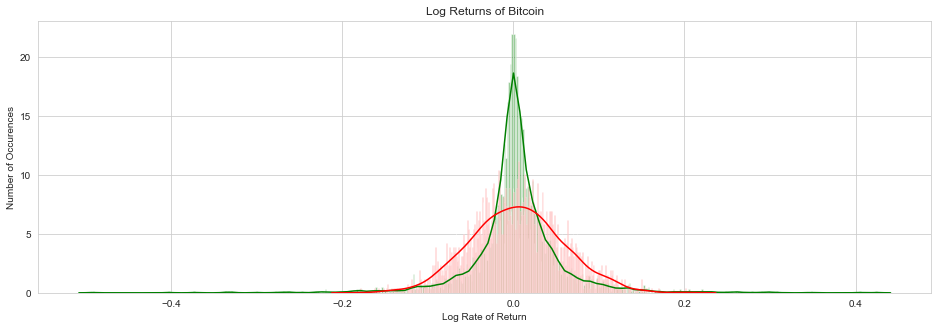

In [11]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,5))
sns.distplot(bitcoin_prices['log_returns'][1:], bins=500, color='green')
sns.distplot(stats.norm.rvs(m,s,len(bitcoin_prices)-1), color='red', bins=500)
plt.xlabel('Log Rate of Return')
plt.ylabel('Number of Occurences')
plt.title('Log Returns of Bitcoin')

This is clearly a bad fit. In particular, the normal distribution is too wide and too flat.  We also see a few spikes very far out if we look very closely.

Next we run a Kolmogorov-Smirnov test on the (normalized) log-returns versus a normal distribution. We will mainly use this in the next section, but we might as well apply it to the log-returns and see how it compares to a normal distribution. The Kolmogorov-Smirnov test uses the the the supremum between two cumulative distribution functions as its test statistic. Concretely, if real-valued random variables $X$ and $Y$ have cumulative distribution functions $F_X$ and $F_Y$ respectively, then their Kolmogorov-Smirnov distance is 
$$d_{KS}(X,Y) = \sup\limits_{t \in \mathbb{R}} | F_X(t) - F_Y(t) |$$
where $F_X(t) = \mathbb{P}(X \leq t)$.

If we are testing a sample (which gives discrete data), then we have to to come up with a cumlative distribution function for the data. The one chosen is the simplest one, we order the data $E=\{x_1, x_2, \ldots, x_N \}$ so that $x_i \leq x_{i+1}$ for $i=1, \ldots, N-1$, and then define the distribtion function $F_E$ for the data by 
$$ F_E (t) = \frac{k}{N}$$
where $k$ is determined by $t\geq x_k$ and $t < x_{k+1}$. In this case, the Kolmogorov-Smirnov distance of the sample from a given distribution $F_X$ is $\sup\limits_{t \in \mathbb{R}} | F_E(t) - F_X(t) |$. Kolmogorov was able to show, assuming the null hypothesis that the samples $E$ are drawn from the distribution $X$, that the distance multiplied by $\sqrt{N}$ will follow a distribution which is independent of the distribution $X$ and whose cumulative distribution function can be written explicitly in terms of a Jacobi theta function. This can then be used to find a $p$-value on which we can potentially reject the null hypothesis that the samples $E$ come from the distribution $X$.

In [12]:
stats.kstest((bitcoin_prices['log_returns'][1:]-m)/s,cdf=stats.distributions.norm.cdf)

KstestResult(statistic=0.13985745927492477, pvalue=6.425442105420721e-58)

Unsurprisingly, this shows that the normalized log-returns do not follow a standard normal distribution. However, one might obejct that we have also used the sample mean and sample standard deviation above, which is a slightly different variable than that used in the usual Kolmogorov-Smirnov test as we are implicitly estimating the mean and standard deviation. To correct for this, we can use a Lilliefors test to get a more accurate $p$-value.

In [13]:
from statsmodels.stats.diagnostic import lilliefors

In [14]:
lilliefors(bitcoin_prices['log_returns'][1:])

(0.13985745927492477, 1.8043626536611448e-183)

This gives the same test statistic, but an even smaller $p$-vlaue, and again the log-normalcy hypothesis is rejected.

Let's compare the quantile distribution of our data with that of a normal distribution:

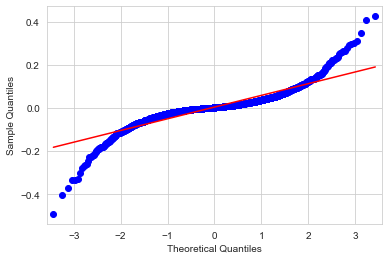

In [15]:
sm.qqplot(bitcoin_prices['log_returns'][1:],line='s');

This probably gives the clearest picture of why log-normalcy fails. We have a distribution that is a poor fit for a straight line, which would be the case if the distribution were a normal one. The 'S'-like curve of the quartile plot of thenormal distribution versus those of the sample sample, falling below the straight line on the left and above it on the right, indicates "fat tails" for distribution of log-returns, i.e. rare events are more likely than for normally distributed data. Indeed, the large standard deviation of the bitcoin log-returns is probably due to tail events.

As an experiment, let us reduce the standard deviation of the normal above to about $\frac{s}{2}$ and see if it looks like a slightly better fit in the central region.

Text(0.5, 1.0, 'Log Returns of Bitcoin')

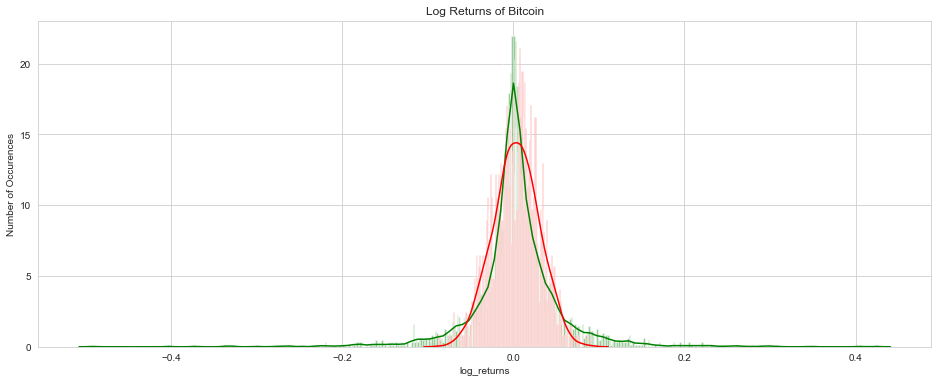

In [16]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,6))
sns.distplot(bitcoin_prices['log_returns'][1:], bins=500, color='green')
sns.distplot(stats.norm.rvs(m,s/2,len(bitcoin_prices['log_returns'])-1), color='red', bins=500)
#plt.xlabel('Log Rate of Return')
plt.ylabel('Number of Occurences')
plt.title('Log Returns of Bitcoin')

In [17]:
stats.kstest((bitcoin_prices['log_returns'][1:]-m)*2/s,cdf=stats.distributions.norm.cdf)

KstestResult(statistic=0.0644588617942834, pvalue=1.225686944926523e-12)

The test results have been marginally improved, but it is still of course a failure. While the center of the distribution is a bit better, as we move out from the mean the normal distribution drops off but the observed data does not. So it is not normally distributed. Power law distributions, Levy distribtuions or Student distributions, are usually better candidates for modelling log returns, but this would require an estimation of the parameters of these distributions (e.g. by maximum likelihood estimation), which is beyond the scope of this post. In practice models with variable standard deviations, such as GARCH$(1,1)$, are also used. This could be done for Bitcoin, but is again beyond the scope of this post.

# 2. $K$ Means Cluster for Volatility Regimes

Here we apply the $K$-means clustering algorithm from the scikit-learn package to find different volatility regimes.

Firts, we will fix the index of our dataframe so we can use the <code>datetime</code> class to find the monthly volatilities.

In [18]:
bitcoin_prices.index=pd.to_datetime(bitcoin_prices.index)

Checking the index, it looks the same, but is a different type now.

In [19]:
bitcoin_prices.head()

,Bitcoin Price (USD),returns,log_returns
Date,,,
2010-08-01,0.0611,NaN,NaN
2010-08-02,0.0600,0.981997,-0.018167
2010-08-03,0.0600,1.000000,0.000000
2010-08-04,0.0570,0.950000,-0.051293
2010-08-05,0.0610,1.070175,0.067823


In [20]:
type(bitcoin_prices.index)

pandas.core.indexes.datetimes.DatetimeIndex

We can also get some basic statistics on the returns and log-returns:

In [21]:
bitcoin_prices.describe()

,Bitcoin Price (USD),returns,log_returns
count,3385.000000,3384.000000,3384.000000
mean,2083.394760,1.005007,0.003528
std,3405.060549,0.054788,0.054177
min,0.057000,0.611745,-0.491440
25%,13.810000,0.986744,-0.013345
50%,415.091000,1.001899,0.001897
75%,2712.157500,1.022234,0.021991
max,19343.040000,1.528947,0.424580


Now let's use the new index to group along months and calculate the standard deviations for each month's worth of data. We will put that into a new dataframe called <code>standard_deviations</code>:

In [22]:
standard_deviations=bitcoin_prices.groupby([bitcoin_prices.index.year,bitcoin_prices.index.month]).std()

In [23]:
standard_deviations.index.names=['Year','Month']

In [24]:
standard_deviations.head()

Bitcoin Price (USD)   returns  log_returns
Year Month                                            
2010 8                 0.003471  0.047491     0.046264
     9                 0.000888  0.021465     0.021482
     10                0.041314  0.083115     0.076269
     11                0.042792  0.141345     0.134372
     12                0.028072  0.075980     0.077556

Notice that this has a multi-level index, by year and then by month. This was unnnecessary, but helps with presentation.

Next, we will import the <code>cluster</code> package from <code>scikit-learn</code> and feed it the returns data. It will apply a $K$-means clustering algorithm to find $K$ cluster centers that try to approximate the clustering of the data. Since this depends on initial random seeds the centers will not allways be identical for each fixed $K$, but should be more or less close together. We are going to do this for each $K=2, \ldots, 19$ and see which gives the best improvement (see below).

In [25]:
from sklearn import cluster

In [26]:
X =np.asarray(standard_deviations['returns']).reshape(-1,1)

Next, we will plot the inertia of each $K$ clustering, for $K=2,\ldots,19$. The inertia is the sum of the squares of the distance of each point to its cluster center. This gives a measure of how good a fit each clustering is, with better fits having lower inertia. Now, this will naturally decrease as $K$ increases, but we want to choose $K=K_i$ so that the inertia for $K_i$ is significantly better than $K_{i-1}$ and not much worse than $K_{i+1}$ (the previous and next clusterings, respectively). This would correspond to an elbow-like turn in the graph below.

In [27]:
distortions=[]
for k in range(2,20):
    distortions.append(cluster.KMeans(n_clusters=k).fit(X).inertia_)

In [28]:
print(distortions)

[0.03186057217776387, 0.016254782821260638, 0.007413568858199583, 0.0046073721487174665, 0.003191233831744993, 0.0023959161825262126, 0.001808626934950621, 0.0013599361924771765, 0.0010521067056973319, 0.0008940738980709722, 0.0007365753203928409, 0.000599952088304652, 0.000496440994826275, 0.00043299977152336564, 0.0003472149523614072, 0.00029436784230553085, 0.000235829773519582, 0.00019206199595569052]


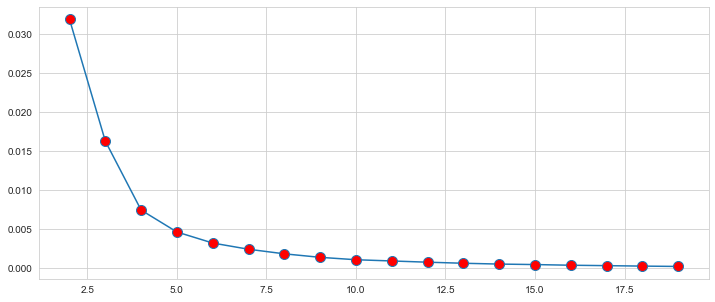

In [29]:
plt.figure(figsize=(12,5))
plt.plot(range(2,20), distortions, marker='o', markerfacecolor='red', markersize=10)

There is a <i>slight</i> elbow at $K=4$, so we'll go with that. Again, this suggests that we have many volatility regimes, corresponding to variable volatility (cf. GARCH$(1,1)$).

In [30]:
kmeans=cluster.KMeans(n_clusters=4)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

The cluster centers (i.e. the 4 numbers the volatilities tend to cluster around, which we will now call 'volatility regimes') are:

In [31]:
print(kmeans.cluster_centers_)

[[0.04493102]
 [0.13319113]
 [0.0800156 ]
 [0.02172587]]


Now, we will add an extra column in the <code>standard_deviations</code> dataframe, telling us what the cluster center is for each month:

In [32]:
standard_deviations['cluster_center']=list(map(lambda x: kmeans.cluster_centers_[x][0], kmeans.predict(X)))

In [33]:
standard_deviations.head()

Bitcoin Price (USD)   returns  log_returns  cluster_center
Year Month                                                            
2010 8                 0.003471  0.047491     0.046264        0.044931
     9                 0.000888  0.021465     0.021482        0.021726
     10                0.041314  0.083115     0.076269        0.080016
     11                0.042792  0.141345     0.134372        0.133191
     12                0.028072  0.075980     0.077556        0.080016

Graphing this, we see a nice approximation of the more complicated volatilities graph by the centers graph (with only 4 $y$-values):

Text(0, 0.5, 'Volatility')

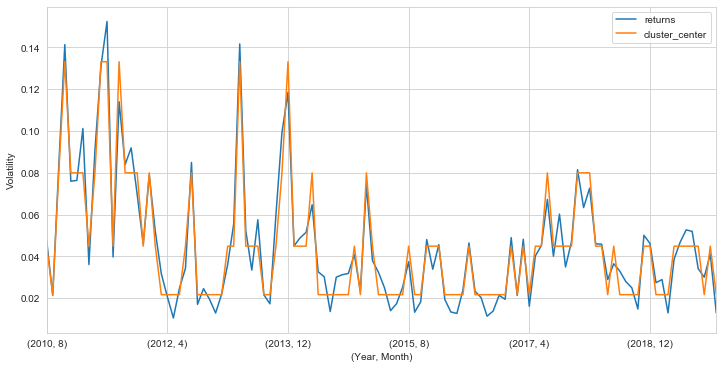

In [34]:
standard_deviations[['returns','cluster_center']].plot(figsize=(12,6))
plt.xlabel('(Year, Month)')
plt.ylabel('Volatility')

This mimics the more complicated time series nicely. Lets produce some tables now, and then calculcate the probabilities of moving from one regime to another.

In [35]:
d_for_clusters={}
for i in range(4):
    d_for_clusters['Cluster '+str(i)] = [list(kmeans.predict(X)).count(i),kmeans.cluster_centers_[i][0]]

In [36]:
pd.DataFrame(d_for_clusters,columns=['Cluster '+str(i) for i in range(4)],
                       index=['Number of Points','Center'])

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
Number of Points,41.000000,6.000000,17.000000,48.000000
Center,0.044931,0.133191,0.080016,0.021726


So this gives a nice little summary of our cluster result. Note that the highly volatile cluster only has 6 points, i.e. we have had 6 months of highly volatile Bitcoin prices. However, the second most volatile cluster has 17 points. Now, let's see what the probabilities are of switching from one regime to another.

In [37]:
d_counts={}
for k in range(4):
    for j in range(4):
        d_counts[(j,k)]=0 
L=list(kmeans.predict(X))
for i in range(len(L)-1):
    d_counts[(L[i],L[i+1])]+=1

The above dictionary has all the necessary data, now we just convert it into a dataframe after doing some division.

In [38]:
prob_matrix=np.zeros((4,4))
for i in range(4):
    for j in range(4):
        prob_matrix[i,j]+=d_counts[(i,j)]
sums=[sum(prob_matrix[i]) for i in range(4)]
for i in range(4):
    prob_matrix[i]/=sums[i]
prob_matrix=prob_matrix.round(2)*100
prob_matrix=np.char.add(prob_matrix.astype(int).astype(str),'%')
cluster_switching_probs = pd.DataFrame(prob_matrix, columns=['Cluster '+str(i) for i in range(4)],
             index=['Cluster '+str(i) for i in range(4)])
cluster_switching_probs.index.name, cluster_switching_probs.columns.name='From', 'To'
cluster_switching_probs['Center']=kmeans.cluster_centers_.round(3)
cluster_switching_probs

To,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Center
From,,,,,
Cluster 0,41%,5%,17%,37%,0.045
Cluster 1,50%,17%,33%,0%,0.133
Cluster 2,35%,18%,35%,12%,0.080
Cluster 3,30%,0%,4%,66%,0.022


So we have a roughly $66\%$ probability of staying in the least volatile regime month-to-month, an approximately $30\%$ chance of jumping into a slightly more volatile regime and a $4\%$ probability to jump to the moderately volatile regime. Most volatility regimes are stable, in the sense that they favor jumping to themselves, except for the most volatile, which tends to favor returning to the most stable regime. This suggests bitcoin builds up to blow offs, after which it returns to relative stability.

Now lets return a Kolmogorov-Smirnov test and see if it agrees with the cluster analysis. We will compute a matrix of monthly distributions of the returns, and then see if the mean intracluster distance (given by the Kolmogorov-Smirnov test for distributions) is less than the mean distance over all distributions. If true, this would suggest (but not prove) that months in the same volatility regime have returns that loosely look like each other. Recall that the Kolmogorov-Smirnov test gives the maximum distance between the graphs of the cumulative distribution function of the samples, so we are ignoring the time-ordering of the data. This whole approach is therefore purely suggestive of some agreement in the overall spread of returns, and is not predictive. We will also check for the mean correlations between clusters, and we will see that there is very little.

In [39]:
monthly_distributions=[]
for i in range(2010,2020):
    for j in range(1,13):
        monthly_distributions.append(
            bitcoin_prices[(bitcoin_prices.index.year==i)&(bitcoin_prices.index.month==j)])
monthly_distributions=monthly_distributions[7:-2]

The first and last few entries are dropped as they are empty. Next, an array containing the Kolmogorov-Smirnov distances is calculated:

In [40]:
n=len(monthly_distributions)
KS_matrix=np.zeros((n,n))
for i in range(n):
    for j in range(n):
        KS_matrix[i,j]+=stats.ks_2samp(monthly_distributions[i]['returns'], 
                                       monthly_distributions[j]['returns'])[0]

Next a similar array containing the monthly correlations is calculated. Since months have differnt lenghts we drop days that are in one month but not the other.

In [41]:
cor_matrix=np.zeros((n-1,n-1))
for i in range(1,n):
    for j in range(1,n):
        l=min(len(monthly_distributions[i]['log_returns']),len(monthly_distributions[j]['log_returns']))
        cor_matrix[i-1,j-1]+=np.corrcoef(monthly_distributions[i]['log_returns'][:l], 
                                     monthly_distributions[j]['log_returns'][:l])[0,1]

The yearly autocorrelations (the correlation between log-returns during one month and a year later) and the Kolmogorov-Smirnov distances between monthly distributions similarly separated by a year, are plotted below.

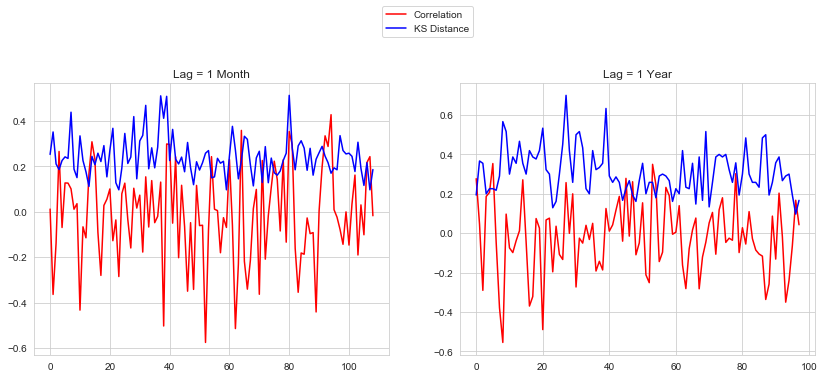

In [42]:
plt.figure(figsize=(14,5))
#plt.xlabel(list(standard_deviations.index))
plt.subplot(1,2,2)
plt.plot([cor_matrix[i,i+12] for i in range(n-13)], color='red')
plt.plot([KS_matrix[i,i+12] for i in range(n-13)], color='blue')
plt.title('Lag = 1 Year')

plt.subplot(1,2,1)
plt.plot([cor_matrix[i,i+1] for i in range(n-2)], color='red')
plt.plot([KS_matrix[i,i+1] for i in range(n-2)], color='blue')
plt.title('Lag = 1 Month')
plt.legend(('Correlation', 'KS Distance'),bbox_to_anchor=(1.25,1.3))

plt.show()

In [43]:
print(np.mean([cor_matrix[i,i+1] for i in range(n-2)]), np.mean([cor_matrix[i,i+12] for i in range(n-13)]))

-0.0165803917788298 -0.0199680150509397


So the mean monthly lag and mean yearly lag autocorrelations for monthly log-returns are both quite small, and negative.

Next, we will calculate the mean Kolmogorov-Smirnov distances between clusters and within clusters.

In [44]:
dist_matrix_clusters=np.zeros((4,4))
divisor={}
for i in range(4):
    for j in range(4):
        divisor[(i,j)]=0
for i in range(n):
    for j in range(n):
        dist_matrix_clusters[kmeans.predict(X)[i],kmeans.predict(X)[j]]+=KS_matrix[i,j]
        divisor[(kmeans.predict(X)[i],kmeans.predict(X)[j])]+=1
for i in range(4):
    for j in range(4):
        dist_matrix_clusters[i,j]/=divisor[(i,j)]

In [45]:
KS_dist_df=pd.DataFrame(dist_matrix_clusters.round(2) , columns=['Cluster '+str(i) for i in range(4)],
             index=['Cluster '+str(i) for i in range(4)])
KS_dist_df.index.name, KS_dist_df.columns.name='From', 'To'
pd.merge(left=KS_dist_df, right=cluster_switching_probs, how='inner', right_index=True,
         left_index=True, suffixes=(' KS dist',' prob'))

To,Cluster 0 KS dist,Cluster 1 KS dist,Cluster 2 KS dist,Cluster 3 KS dist,Cluster 0 prob,Cluster 1 prob,Cluster 2 prob,Cluster 3 prob,Center
From,,,,,,,,,
Cluster 0,0.25,0.31,0.28,0.30,41%,5%,17%,37%,0.045
Cluster 1,0.31,0.19,0.26,0.39,50%,17%,33%,0%,0.133
Cluster 2,0.28,0.26,0.24,0.37,35%,18%,35%,12%,0.080
Cluster 3,0.30,0.39,0.37,0.25,30%,0%,4%,66%,0.022


So the intracluster Kolmogorov-Smirnov distances are smaller than the mean distances between members of different clusters, and than the mean Kolmogorov-Smirnov distance. The mean Kolmogorov-Smirnov distances above also mostly separate clusters in proportion to how different their volatilites are (there are some exceptions with middle volatility clusters).

Interestingly, if we assume that all months have $n=30$ days, the cut off to reject the null hypothesis (i.e. to say that the distributions are different) with $p$-value $p=.10$ or $p=.05$ are Kolmogorov-Smirnov distances higher than $0.287$ or $0.327$, respectively. This suggests (but doe NOT imply, as we are not being rigorous right now) that the months in the same cluster may have "on average" similar distributions, but, for instance, we can "on average" reject that the most volatile clusters and the least volatile clusters have the same distribution. Again, this only suggests this, it is not rigorous, as the average Kolmogorov-Smirnov distance is a random variable in its own right and would have to be further analyzed to determine what would be the correct $p$-value for rejecting the null hypothesis. The small mean Kolmogorov-Smirnov distance in the most volatile cluster is particularly suggestive in this regard.

For reference, the average Kolmogorov-Smirnov distance between distributions is

In [46]:
print(np.sum(KS_matrix)/(n*(n-1)))

0.29764509955833646


In [47]:
print('A p-value of .10 for anything higher than',1.073/np.sqrt(15),'and',
      '\n','a p-value of .05 for anything higher than', 1.224/np.sqrt(15))

A p-value of .10 for anything higher than 0.27704740869870387 and 
 a p-value of .05 for anything higher than 0.3160354410505252


Now, the Kolmogorov-Smirnov distance does not take into account the time-ordered nature of the returns. If we instead consider the <i>correlations</i> between the monthly log-returns, we get a more cautious result.

In [48]:
cor_matrix_clusters=np.zeros((4,4))
for i in range(1,n):
    for j in range(1,n):
        cor_matrix_clusters[kmeans.predict(X)[i],kmeans.predict(X)[j]]+=cor_matrix[i-1,j-1]
for i in range(4):
    for j in range(4):
        cor_matrix_clusters[i,j]/=divisor[(i,j)]

In [49]:
mean_corr_df=pd.DataFrame(cor_matrix_clusters.round(4), columns=['Cluster '+str(i) for i in range(4)],
             index=['Cluster '+str(i) for i in range(4)])
mean_corr_df.index.name, mean_corr_df.columns.name ='From', 'To'
pd.merge(left=mean_corr_df, right=cluster_switching_probs, how='inner', right_index=True,
         left_index=True, suffixes=(' corr',' prob'))

To,Cluster 0 corr,Cluster 1 corr,Cluster 2 corr,Cluster 3 corr,Cluster 0 prob,Cluster 1 prob,Cluster 2 prob,Cluster 3 prob,Center
From,,,,,,,,,
Cluster 0,0.0166,0.0028,0.0019,-0.0022,41%,5%,17%,37%,0.045
Cluster 1,0.0028,0.1652,-0.0439,-0.0255,50%,17%,33%,0%,0.133
Cluster 2,0.0019,-0.0439,0.0665,0.0167,35%,18%,35%,12%,0.080
Cluster 3,-0.0022,-0.0255,0.0167,0.0208,30%,0%,4%,66%,0.022


So the Kolmogorov-Smirnov distance seems to be better than correlation at detecting clusters. The highest correlation between monthly log-returns in the most volatile cluster again may suggest that when Bitcoin got highly volatile, it may have followed a pattern. However, this is most likely a consequence of the fact that there are only 6 points in this cluster, which is much smaller than the other clusters.